In [1]:
import functions_idealized
import functions_grid
import functions_realistic
import scipy as sc, scipy.io
import numpy as np
import colormap_ibcao

import matplotlib.pyplot as plt
%matplotlib inline

# Set up

In [2]:
ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x_ibcao = ibcao_file.variables['x'][:]
y_ibcao = ibcao_file.variables['y'][:]
z_ibcao = ibcao_file.variables['z'][:]
xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x_ibcao==xl)[0][0]
xmax = np.where(x_ibcao==xr)[0][0]
ymin = np.where(y_ibcao==yb)[0][0]
ymax = np.where(y_ibcao==yt)[0][0]
x_region = x_ibcao[xmin:xmax]
y_region = y_ibcao[ymin:ymax]
z_region = z_ibcao[ymin:ymax, xmin:xmax]

In [3]:
extension = 20
x_orig = 120
y_orig = int(0.75 * x_orig)
search_x = [-1100000, -1450000, -1750000, -1400000]
x_orig, y_orig

(120, 90)

# 1. Mackenzie Canyon Dimensions

In [4]:
w_break, w_mid, w_head, width_f, x_wall, mouth, length, y_wall_1300, y_wall, adjust, cR, L, y_base, y_break,\
y_coast, y_head, fluid_depth, z_bottom, z_break, z_wall, p = functions_idealized.define_Mackenzie_measurements()

# 2. Domain Boundaries

In [5]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall, y_wall, search_x)

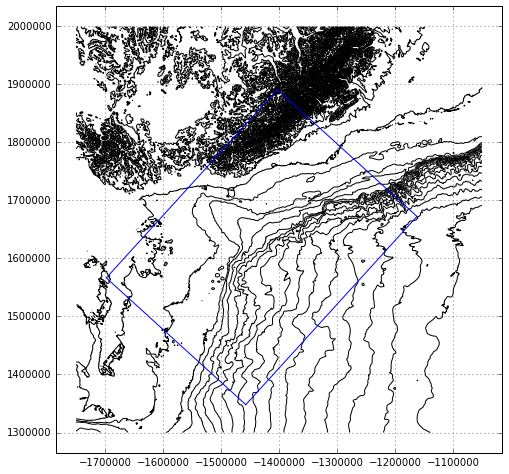

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')

ax.plot(lon_s_corners, lat_s_corners, 'b')
ax.plot(lon_s_corners[0::3], lat_s_corners[0::3], 'b')
ax.scatter(lon_s_corners[1], lat_s_corners[1], c = 'r', s = 40)

# 3. Coordinate Grid

In [7]:
nx = x_orig
ny = y_orig

In [8]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lon_g_grid, lat_g_grid = functions_grid.create_grid(nx, ny, lon_g_corners, lat_g_corners)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

(120, 90)

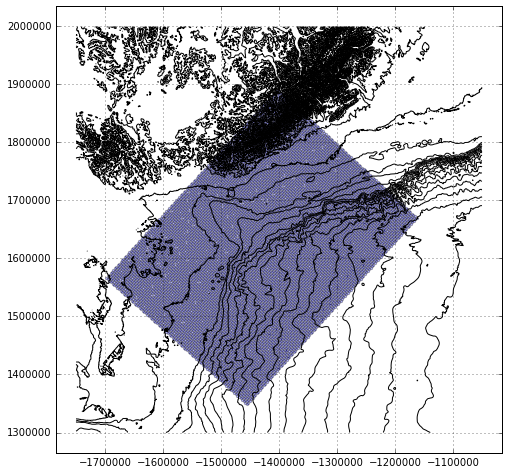

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.scatter(lon_s_grid, lat_s_grid, c='b', s=5, alpha=0.3)

lon_s_grid.shape

# 4. Realistic Bathymetry

In [10]:
z_canyon = functions_realistic.positive_canyon(fluid_depth, extension, lon_s_grid, lat_s_grid, 
                                                x_region, y_region, z_region, 'linear')

(87, 137)

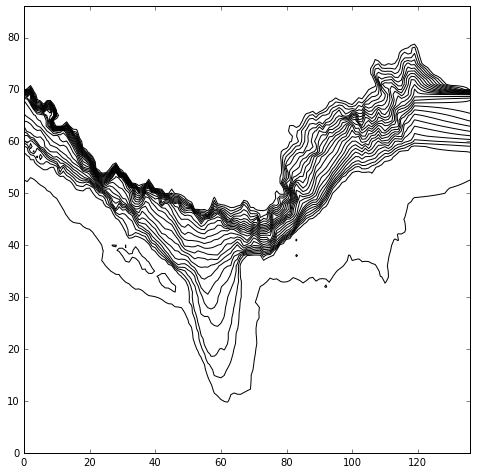

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contour(z_canyon, 25, colors = 'k')
ax.contour(z_canyon, levels = [-80, -40.1], colors='k', linestyles='solid')

z_canyon.shape

# 5. Domain Boundaries - Extended

In [12]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
extension_m = dx * 1000 * extension

In [13]:
x_wall_ext = x_wall + extension_m
lon_s_corners_ext, lat_s_corners_ext = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

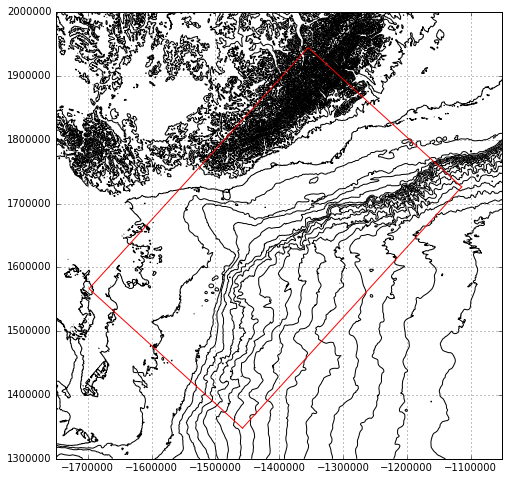

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')

ax.plot(lon_s_corners_ext, lat_s_corners_ext, 'r')
ax.plot(lon_s_corners_ext[0::3], lat_s_corners_ext[0::3], 'r')

# 6. Coordinate Grid - Extended

In [15]:
nx_extended = nx + extension

In [16]:
lon_g_corners_ext, lat_g_corners_ext = functions_grid.transform_coords(lon_s_corners_ext, lat_s_corners_ext, 'SG')

lon_g_grid_ext, lat_g_grid_ext = functions_grid.create_grid(nx_extended, ny, lon_g_corners_ext, lat_g_corners_ext)

lon_s_grid_ext, lat_s_grid_ext = functions_grid.transform_coords(lon_g_grid_ext, lat_g_grid_ext, 'GS')

(140, 90)

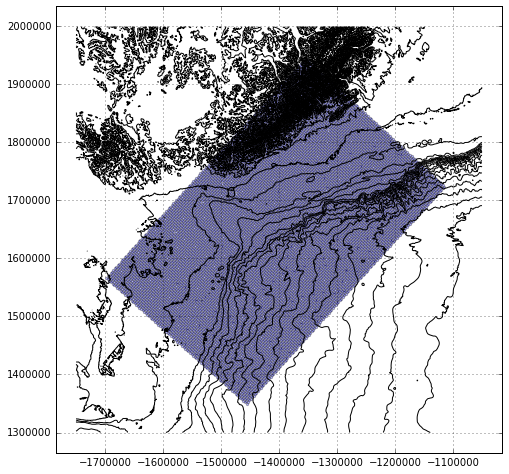

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.scatter(lon_s_grid_ext, lat_s_grid_ext, c='b', s=5, alpha=0.3)

lon_s_grid_ext.shape

# 7. Idealized Canyon

In [18]:
xsize = y_orig - 3 + 1
ysize = x_orig + extension - 3 + 1

In [19]:
x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

bathymetry = functions_idealized.make_topo_smooth(y_edge, y_base, y_break, y_head, y_coast, cR, L,
                                             x, x_wall, w_break, w_mid, w_head, p,
                                             fluid_depth, z_bottom, z_break, z_wall)

(137, 87)

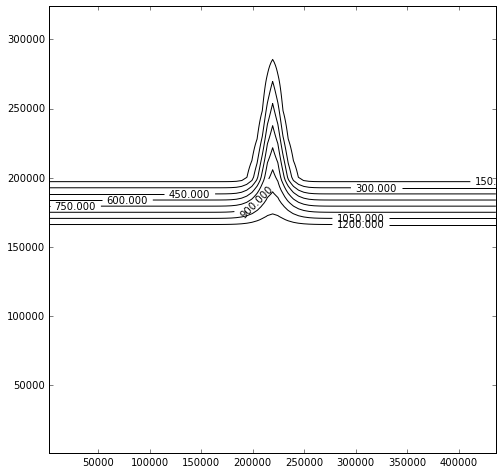

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cs = ax.contour(X, Y, bathymetry, 10, colors='k', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [-1300, -80, -60, -40.1], colors='k',linestyles='solid')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)

bathymetry.shape